In [2]:
from pymongo import MongoClient
import logging

# Configure logging
logging.basicConfig(filename='analysis_log.txt', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

client = MongoClient("mongodb://localhost:27017/")
db = client.bachelor

reports_count = db.reports.count_documents({})
packages_count = db.packages.count_documents({})
# Wie viele Berichte gibt es?
print(f"Anzahl der Berichte: {reports_count}")
# Wie viele Pakete gibt es?
print(f"Anzahl der Pakete: {packages_count}")

Anzahl der Berichte: 7709
Anzahl der Pakete: 14257


In [3]:
# Wie viele Scans gibt es?

scan_counter = 0
for scan in db.configscan.find({}):
    scan_counter += 1

print(f"Anzahl der Scans: {scan_counter}")

Anzahl der Scans: 10432


Durchschnittliche Anzahl der Konfigurationsfehler: 11.1428760068665
Median der Konfigurationsfehler: 5
Standardabweichung der Konfigurationsfehler: 20.78762574388169
Anzahl der Konfigurationsfehler insgesamt: 115174


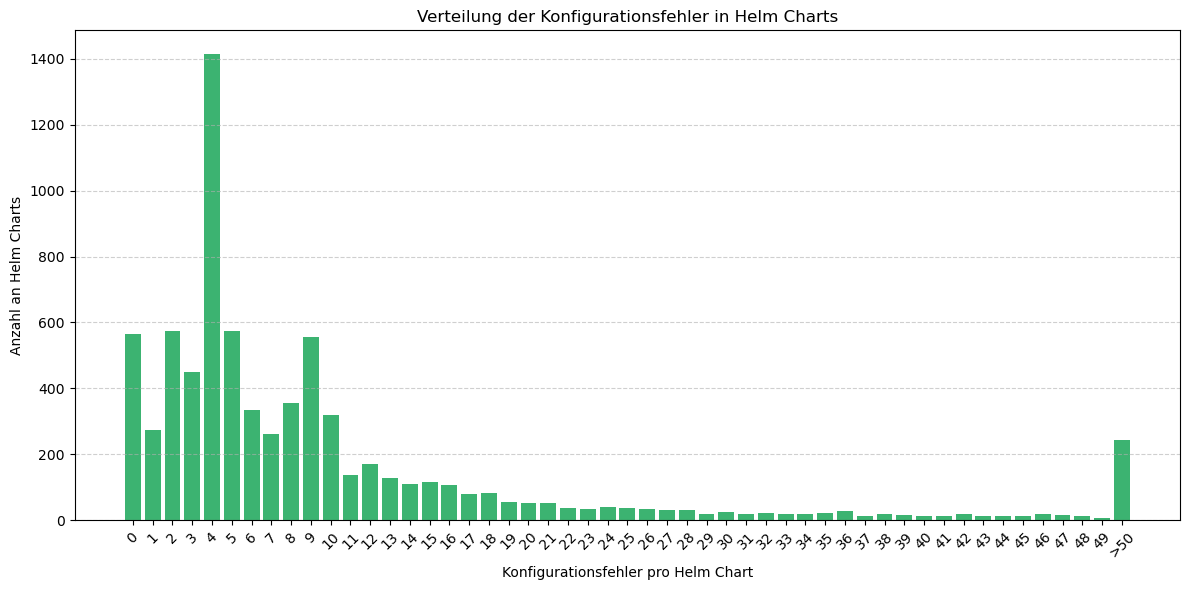

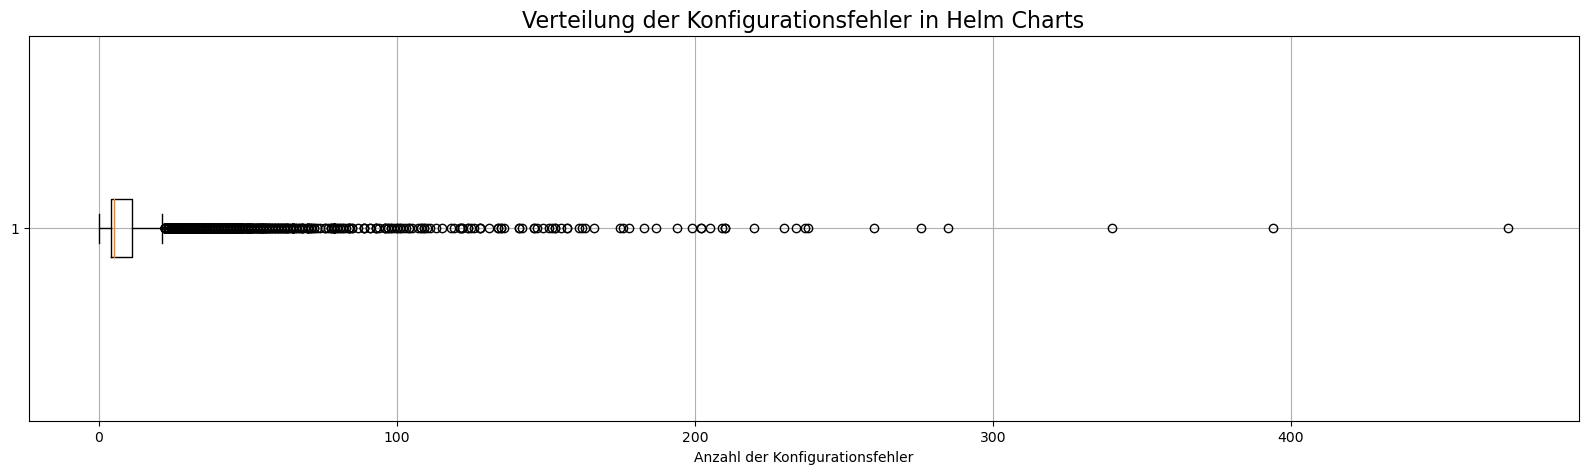

In [8]:
from statistics import median, mean, stdev
# Wie viele Konfigurationsfehler gibt es?

config_list = {}
config_counter = 0
for scan in db.configscan.find({}):
    reports = scan["linter_output"]["Reports"]
    name = scan["name"]
    if reports is not None:
        config_list[name] = len(reports)
        config_counter += len(reports)
    else:
        config_list[name] = 0

config_values = list(config_list.values())

config_mean = mean(config_values)
config_median = median(config_values)
config_stdev = stdev(config_values)

print(f"Durchschnittliche Anzahl der Konfigurationsfehler: {config_mean}")
print(f"Median der Konfigurationsfehler: {config_median}")
print(f"Standardabweichung der Konfigurationsfehler: {config_stdev}")
print(f"Anzahl der Konfigurationsfehler insgesamt: {config_counter}")


import matplotlib.pyplot as plt
from collections import defaultdict

groups = defaultdict(int)

for chart, count in config_list.items():
    if count >= 50:
        label = ">50"
    else:
        label = f"{count}"
    groups[label] += 1

def sort_key(label):
    if label == ">50":
        return 10000
    return int(label.split("-")[0])

labels = sorted(groups.keys(), key=sort_key)
values = [groups[label] for label in labels]

plt.figure(figsize=(12, 6))
plt.bar(labels, values, color="mediumseagreen")
plt.xlabel("Konfigurationsfehler pro Helm Chart")
plt.ylabel("Anzahl an Helm Charts")
plt.title("Verteilung der Konfigurationsfehler in Helm Charts")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


plt.figure(figsize=(20, 5))

# Boxplot
plt.boxplot(config_values, 
            vert=False,         
            showfliers=True)
plt.title("Verteilung der Konfigurationsfehler in Helm Charts", fontsize=16)
plt.xlabel("Anzahl der Konfigurationsfehler")
plt.grid(True)
plt.show()


Anzahl der Helm Charts mit Fehlkonfigurationsscan und Schwachstellen Scan: 6005


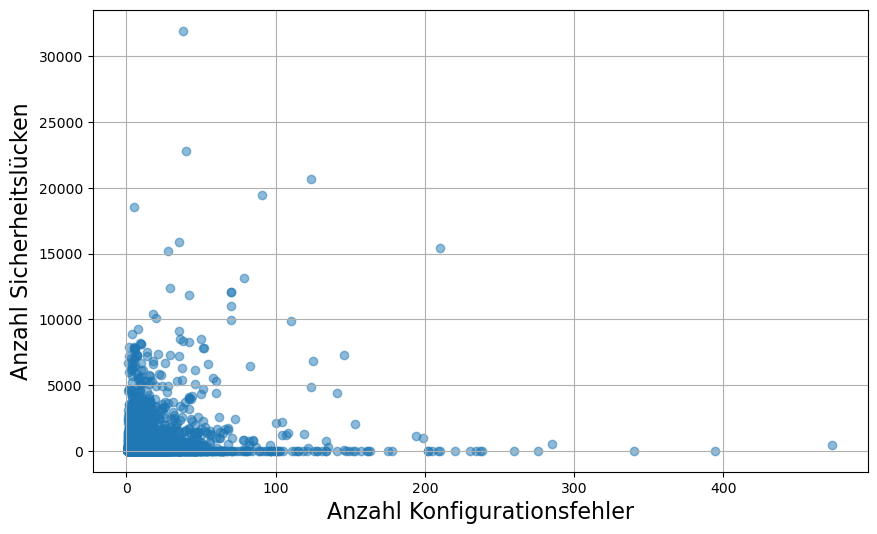

In [13]:
import matplotlib.pyplot as plt
# Zusammenhang zwischen Anzahl der Schwachstellen pro Image und Anzahl der Konfigurationsfehler

helm_charts = {}

for scan in db.configscan.find({}):
    name = scan["name"]
    repository = scan["repository"]
    version = scan["version"]
    scan_report = scan["linter_output"]["Reports"]

    package = db.packages.find_one({"name": name, "repository.name": repository, "version": version})

    if package and scan_report is not None:
        misconfig_counter = len(scan_report)

        total_vulnerabilities = 0
        if "security_report_summary" in package and package['security_report_summary']:
            for severity in package['security_report_summary'].values():
                total_vulnerabilities += severity
        helm_charts[name] = {
            "misconfigurations": misconfig_counter,
            "vulnerabilities": total_vulnerabilities
        }

print(f"Anzahl der Helm Charts mit Fehlkonfigurationsscan und Schwachstellen Scan: {len(helm_charts)}")

misconfigurations = [chart["misconfigurations"] for chart in helm_charts.values()]
vulnerabilities = [chart["vulnerabilities"] for chart in helm_charts.values()]

plt.figure(figsize=(10, 6))
plt.scatter(misconfigurations, vulnerabilities, alpha=0.5)
plt.xlabel("Anzahl Konfigurationsfehler", fontsize=16)
plt.ylabel("Anzahl Sicherheitslücken", fontsize=16)
plt.grid(True)
plt.show()

        
    

In [11]:
from scipy.stats import pearsonr, spearmanr

pearson_corr, pearson_p = pearsonr(misconfigurations, vulnerabilities)
spearman_corr, spearman_p = spearmanr(misconfigurations, vulnerabilities)

print(f"Pearson-Korrelation: {pearson_corr:.3f} (p-Wert: {pearson_p:.3f})")
print(f"Spearman-Korrelation: {spearman_corr:.3f} (p-Wert: {spearman_p:.3f})")

Pearson-Korrelation: 0.156 (p-Wert: 0.000)
Spearman-Korrelation: 0.146 (p-Wert: 0.000)


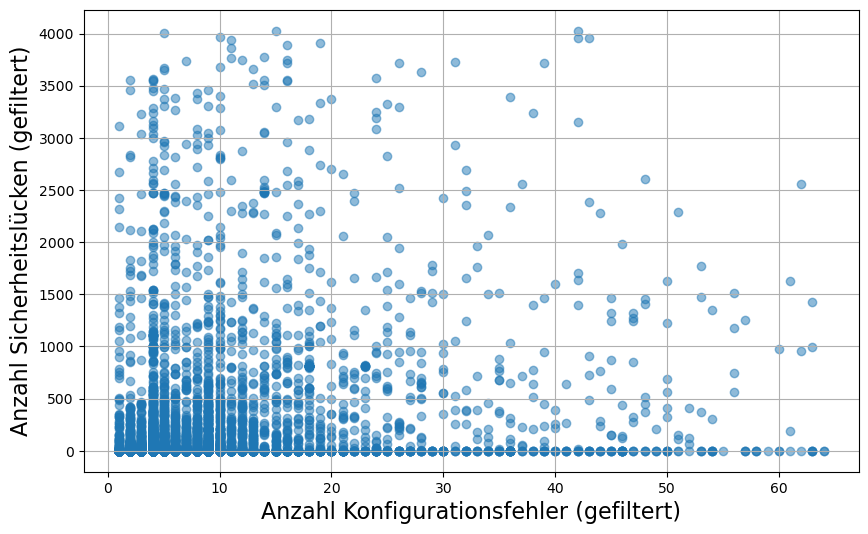

In [12]:
# Streudiagramm ohne Ausreißer
import numpy as np
import matplotlib.pyplot as plt

misconfig = np.array(misconfigurations)
vuln = np.array(vulnerabilities)

lower_p = 2
upper_p = 98
mis_min, mis_max = np.percentile(misconfig, [lower_p, upper_p])
vuln_min, vuln_max = np.percentile(vuln, [lower_p, upper_p])

mask = (
    (misconfig >= mis_min) & (misconfig <= mis_max) &
    (vuln >= vuln_min) & (vuln <= vuln_max)
)

mis_filt = misconfig[mask]
vuln_filt = vuln[mask]

plt.figure(figsize=(10, 6))
plt.scatter(mis_filt, vuln_filt, alpha=0.5)
plt.xlabel("Anzahl Konfigurationsfehler (gefiltert)", fontsize=16)
plt.ylabel("Anzahl Sicherheitslücken (gefiltert)", fontsize=16)
plt.grid(True)
plt.show()

In [3]:
# Häufigster Konfigurationsfehler
check_list = {}

for scan in db.configscan.find({}):
    reports = scan["linter_output"]["Reports"]
    if reports is not None:
        for report in reports:
            if "Check" in report:
                if report["Check"] in check_list:
                    check_list[report["Check"]] += 1
                else:
                    check_list[report["Check"]] = 1

sorted_checks = sorted(check_list.items(), key=lambda x: x[1], reverse=True)
print("Häufigste Konfigurationsfehler:")
for check, count in sorted_checks:
    print(f"{check}: {count} Vorkommen")

print(f"Anzahl der verschiedenen Konfigurationsfehler: {len(check_list)}")

Häufigste Konfigurationsfehler:
no-read-only-root-fs: 27708 Vorkommen
unset-memory-requirements: 25077 Vorkommen
unset-cpu-requirements: 23354 Vorkommen
run-as-non-root: 20414 Vorkommen
latest-tag: 5605 Vorkommen
no-anti-affinity: 1291 Vorkommen
privilege-escalation-container: 1176 Vorkommen
dangling-service: 1175 Vorkommen
liveness-port: 1169 Vorkommen
readiness-port: 1154 Vorkommen
privileged-container: 993 Vorkommen
no-extensions-v1beta: 949 Vorkommen
non-existent-service-account: 940 Vorkommen
sensitive-host-mounts: 911 Vorkommen
host-network: 609 Vorkommen
drop-net-raw-capability: 593 Vorkommen
env-var-secret: 565 Vorkommen
pdb-unhealthy-pod-eviction-policy: 326 Vorkommen
host-pid: 305 Vorkommen
deprecated-service-account-field: 303 Vorkommen
startup-port: 149 Vorkommen
mismatching-selector: 128 Vorkommen
ssh-port: 71 Vorkommen
pdb-min-available: 67 Vorkommen
docker-sock: 57 Vorkommen
duplicate-env-var: 30 Vorkommen
unsafe-sysctls: 19 Vorkommen
host-ipc: 18 Vorkommen
invalid-targe

In [6]:
# Helm Chart mit den meisten Konfigurationsfehlern
most_errors_chart = max(config_list, key=config_list.get)
most_errors_count = config_list[most_errors_chart]
print(f"Helm Chart mit den meisten Konfigurationsfehlern: {most_errors_chart} mit {most_errors_count} Fehlern")

Helm Chart mit den meisten Konfigurationsfehlern: openebs mit 473 Fehlern


In [7]:
# Beliebtheit vs Anzahl der Konfigurationsfehler
helm_charts = {}

for scan in db.configscan.find({}):
    name = scan["name"]
    repository = scan["repository"]
    version = scan["version"]
    scan_report = scan["linter_output"]["Reports"]

    package = db.packages.find_one({"name": name, "repository.name": repository, "version": version})

    if package and scan_report is not None:
        misconfig_counter = len(scan_report)

        subscriptions = int(package["stats"]["subscriptions"])
        helm_charts[name] = {
            "misconfigurations": misconfig_counter,
            "subscriptions": subscriptions
        }

print(f"Anzahl der Helm Charts mit Fehlkonfigurationsscan und Schwachstellen Scan: {len(helm_charts)}")

Anzahl der Helm Charts mit Fehlkonfigurationsscan und Schwachstellen Scan: 6005


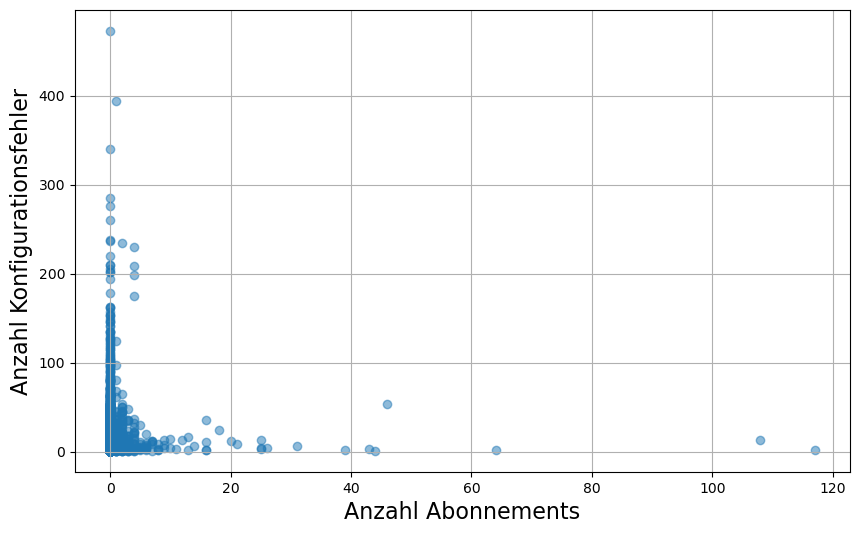

Pearson-Korrelation: 0.003 (p-Wert: 0.789)
Spearman-Korrelation: 0.027 (p-Wert: 0.036)


In [9]:
import matplotlib.pyplot as plt
misconfigurations = [chart["misconfigurations"] for chart in helm_charts.values()]
subscriptions = [chart["subscriptions"] for chart in helm_charts.values()]

plt.figure(figsize=(10, 6))
plt.scatter(subscriptions, misconfigurations, alpha=0.5)
plt.xlabel("Anzahl Abonnements", fontsize=16)
plt.ylabel("Anzahl Konfigurationsfehler", fontsize=16)
plt.grid(True)
plt.show()

from scipy.stats import pearsonr, spearmanr

pearson_corr, pearson_p = pearsonr(subscriptions, misconfigurations)
spearman_corr, spearman_p = spearmanr(subscriptions, misconfigurations)

print(f"Pearson-Korrelation: {pearson_corr:.3f} (p-Wert: {pearson_p:.3f})")
print(f"Spearman-Korrelation: {spearman_corr:.3f} (p-Wert: {spearman_p:.3f})")